In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 30)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import shapiro 
import phik

import warnings
warnings.filterwarnings("ignore")

# **1. Data Understanding**

Dataset berisi rekam perjalanan **Green Taxi** pada bulan **Januari 2023** yang dipublikasikan oleh **New York City (NYC) Taxi & Limousine Commission (TLC)** (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Pemahaman dataset akan ditinjau dari segi: tipe data, duplikasi data, statistik deskriptif, missing values, dan outliers.

## **1.1 Data Types**

In [2]:
def skim_dtype(df):
    df_info = pd.DataFrame({
        'attribute': df.columns.values,
        'data_type': df.dtypes.values,
        'n_unique': df.nunique().values,
        'sample_unique': [df[col].unique() for col in df.columns.values]
    }).reset_index(drop=True)
    print(f'rows, columns: {df.shape[0]}, {df.shape[1]}')
    return df_info

In [3]:
df = pd.read_csv('../data/raw/NYC_TLC_Trip_Record.csv')
skim_dtype(df)

rows, columns: 68211, 20


,attribute,data_type,n_unique,sample_unique
0,VendorID,int64,2,"[2, 1]"
1,lpep_pickup_datetime,object,66575,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 2023-01-01 00:35:12, 2023-01-01 00:13:14, 2023-01-01 00:33:04, 2023-01-01 00:53:31, 2023-01-01 00:09:14, 2023-01-01 00:11:58, 2023-01-01 00:41:29, 2023-01-01 00:50:32, 2023-01-01 00:16:12, 2023-01-01 00:08:43, 2023-01-01 00:26:32, 2023-01-01 00:18:35, 2023-01-01 00:39:32, 2023-01-01 00:49:34, 2023-01-01 00:10:45, 2023-01-01 00:35:11, 2023-01-01 00:31:06, 2023-01-01 00:14:37, 2023-01-01 00:26:21, 2023-01-01 00:41:56, 2023-01-01 00:32:02, 2023-01-01 00:55:13, 2023-01-01 00:01:31, 2023-01-01 00:22:31, 2023-01-01 00:57:28, 2023-01-01 00:35:21, 2023-01-01 00:52:52, 2023-01-01 00:32:56, 2023-01-01 00:24:01, 2023-01-01 00:46:48, 2023-01-01 00:40:58, 2023-01-01 00:20:23, 2023-01-01 01:49:24, 2023-01-01 00:41:53, 2023-01-01 00:56:26, 2023-01-01 00:33:10, 2023-01-01 00:58:28, 2023-01-01 00:42:49, 2023-01-01 00:48:21, 2023-01-01 00:08:05, 2023-01-01 00:13:47, 2023-01-01 00:16:10, 2023-01-01 00:04:25, 2023-01-01 00:33:38, 2023-01-01 00:46:08, 2023-01-01 01:00:08, 2023-01-01 00:28:04, 2023-01-01 00:23:04, 2023-01-01 00:34:07, 2023-01-01 00:52:03, 2023-01-01 00:25:31, 2023-01-01 00:53:09, 2023-01-01 00:42:37, 2023-01-01 00:39:52, 2023-01-01 00:15:32, 2023-01-01 00:06:48, 2023-01-01 00:57:15, 2023-01-01 00:14:13, 2023-01-01 00:52:48, 2023-01-01 00:34:13, 2023-01-01 00:44:41, 2023-01-01 00:11:12, 2023-01-01 01:44:43, 2023-01-01 01:04:44, 2023-01-01 01:48:11, 2023-01-01 01:11:39, 2023-01-01 01:54:25, 2023-01-01 01:59:10, 2023-01-01 01:22:35, 2023-01-01 01:37:10, 2023-01-01 01:46:22, 2023-01-01 01:59:48, 2023-01-01 01:09:49, 2023-01-01 01:23:35, 2023-01-01 01:53:20, 2023-01-01 01:32:14, 2023-01-01 01:01:05, 2023-01-01 01:34:41, 2023-01-01 01:52:08, 2023-01-01 01:49:28, 2023-01-01 01:03:59, 2023-01-01 01:13:11, 2023-01-01 01:40:06, 2023-01-01 01:33:50, 2023-01-01 01:45:19, 2023-01-01 01:51:29, 2023-01-01 01:34:07, 2023-01-01 01:10:08, 2023-01-01 01:32:17, 2023-01-01 01:48:28, 2023-01-01 01:30:43, 2023-01-01 01:51:10, 2023-01-01 01:09:36, 2023-01-01 01:19:54, 2023-01-01 01:31:10, 2023-01-01 01:42:30, 2023-01-01 00:57:51, 2023-01-01 01:27:36, ...]"
2,lpep_dropoff_datetime,object,66519,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 2023-01-01 00:41:32, 2023-01-01 00:19:03, 2023-01-01 00:39:02, 2023-01-01 01:11:04, 2023-01-01 00:26:39, 2023-01-01 00:24:55, 2023-01-01 00:46:26, 2023-01-01 01:13:42, 2023-01-01 00:41:43, 2023-01-01 00:17:08, 2023-01-01 00:45:31, 2023-01-01 00:30:09, 2023-01-01 01:18:06, 2023-01-01 01:08:23, 2023-01-01 00:19:37, 2023-01-01 01:17:35, 2023-01-01 00:42:23, 2023-01-01 00:21:50, 2023-01-01 00:30:26, 2023-01-01 00:46:06, 2023-01-01 00:41:25, 2023-01-01 00:59:47, 2023-01-01 00:16:02, 2023-01-01 00:39:24, 2023-01-01 01:09:31, 2023-01-01 00:53:49, 2023-01-01 01:00:53, 2023-01-01 00:42:53, 2023-01-01 00:32:05, 2023-01-01 01:08:17, 2023-01-01 01:04:32, 2023-01-01 00:24:32, 2023-01-01 01:57:51, 2023-01-01 00:41:58, 2023-01-01 01:14:41, 2023-01-01 00:43:08, 2023-01-01 01:14:46, 2023-01-01 00:51:53, 2023-01-01 01:23:50, 2023-01-01 00:13:26, 2023-01-01 00:25:57, 2023-01-01 00:54:55, 2023-01-01 00:17:50, 2023-01-01 00:38:51, 2023-01-01 00:59:10, 2023-01-01 01:05:46, 2023-01-01 00:43:45, 2023-01-01 23:18:32, 2023-01-01 00:50:01, 2023-01-01 00:57:56, 2023-01-01 00:38:40, 2023-01-01 01:13:35, 2023-01-01 00:47:15, 2023-01-01 00:48:54, 2023-01-01 00:23:03, 2023-01-01 01:08:47, 2023-01-01 01:00:15, 2023-01-01 00:25:43, 2023-01-01 01:21:19, 2023-01-01 00:43:57, 2023-01-01 00:48:26, 2023-01-01 00:38:12, 2023-01-01 01:57:31, 2023-01-01 01:11:23, 2023-01-01 02:05:51, 2023-01-01 01:41:21, 2023-01-01 02:05:19, 2023-01-01 02:11:36, 2023-01-01 01:25:11, 2023-01-01 01:41:30, 2023-01-01 02:04:14, 2023-01-01 02:05:29, 2023-01-01 01:17:55, 2023-01-01 01:53:43, 2023-01-01 02:27:01, 2023-01-01 01:43:55, 2023-01-01 01:13:02, 2023-01-01 02:00:06, 2023-01-01 02:00:57, 2023-01-01 02:13:18, 2023-01-01 01:07:17, 20

<u>**Insight**</u>
<br>Di dataset ini, tipe data atribut (yang terlihat dari skimming data awal) beserta keterangannya (referensi: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf) adalah sebagai berikut:

* Tipe data: Numerical, Discrete
    * VendorID: Nomor ID dari provider teknologi yang menyediakan rekam data perjalanan
    * RatecodeID: Jenis tarif dasar berdasarkan rute perjalanan, bergantung pada lokasi tujuan/drop-off
    * PULocationID: Nomor ID dari lokasi pick-up
    * DOLocationID: Nomor ID dari lokasi drop-off
    * passenger_count: Jumlah penumpang, merupakan nilai yang dimasukkan oleh driver
    * extra: Tarif tambahan lain-lain seperti tarif rush hour atau overnight
    * mta_tax: Tarif pajak
    * tolls_amount: Tarif tambahan ketika melalui jalan tol
    * ehail_fee: Keterangan atribut tidak tersedia pada referensi, tetapi diasumsikan sebagai tarif tambahan ketika taxi dipesan melalui aplikasi
    * improvement_surcharge: Tarif tambahan untuk perbaikan/maintenance layanan
    * congestion_surcharge: Tarif tambahan ketika ada kemacetan
    * payment_type: Cara pembayaran
    * trip_type: Jenis perjalanan berupa street-hail (dipesan langsung di jalan) dan dispatch (dipesan melalui panggilan ke pangkalan)
* Tipe data: Numerical, Continuous
    * trip_distance: Jarak tempuh perjalanan dalam mil
    * fare_amount: Tarif perjalanan berdasarkan jarak tempuh dan durasi perjalanan
    * tip_amount: Tip yang dibayarkan secara credit card
    * total_amount: Total yang dibayar penumpang di luar tip secara cash
* Tipe data: Datetime
    * lpep_pickup_datetime: Waktu pickup ketika taximeter mulai dijalankan, format YYYY-MM-DD HH:MM:SS
    * lpep_dropoff_datetime: Waktu drop-off ketika taximeter mulai dijalankan, format YYYY-MM-DD HH:MM:SS
* Tipe data: Categorical, Nominal
    * store_and_fwd_flag: Keterangan jika driver terhubung ke server saat perjalanan (Y) atau tidak (N). Jika tidak, rekaman data diupdate ke server kemudian

Untuk kemudahan pengolahan data selanjutnya, beberapa nama dan susunan kolom diubah.

In [4]:
# mengubah nama kolom
df.rename(columns={
    'lpep_pickup_datetime': 'pickup_datetime',
    'lpep_dropoff_datetime': 'dropoff_datetime',
}, inplace=True)

# mengubah susunan kolom untuk mengelompokkan atribut tarif
df = df[['VendorID', 'pickup_datetime', 'dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'congestion_surcharge', 'total_amount', 'payment_type', 'trip_type']]

# do this later, but when?
# df.sort_values(by='pickup_datetime', ascending=True, inplace=True)

<u>**Insight**</u>
<br>Ada beberapa tipe data atribut yang harus dikoreksi yaitu:
* Kolom pickup_datetime, dropoff_datetime berupa **object** seharusnya **datetime64[s]**
* Kolom RatecodeID, passenger_count, payment_type, trip_type berupa **float64** karena adanya missing values, ketika tidak ada missing values seharusnya **int64**
* Kolom dengan tipe data numerical, discrete diubah menjadi **object**

Tipe data kolom yang seharusnya merupakan datetime dan beberapa kolom yang seharusnya merupakan object (selain kolom-kolom tarif) akan dikoreksi saat ini supaya bisa melakukan pemahaman data lebih lanjut dari segi statistik deskriptif. Pembuatan kolom baru berupa durasi perjalanan dalam detik (trip_duration_seconds) juga dilakukan untuk bisa mendeteksi outlier durasi perjalanan. Durasi perjalanan didapatkan dari selisih waktu drop-off dan pickup dan mempunyai tipe data numerical, continuous.

In [5]:
df = df.astype({
    'pickup_datetime': 'datetime64[s]',
    'dropoff_datetime': 'datetime64[s]',
    'VendorID': 'object',
    'RatecodeID': 'object',
    'PULocationID': 'object',
    'DOLocationID': 'object',
    'passenger_count': 'object',
    'payment_type': 'object',
    'trip_type': 'object'
})

df.insert(loc=3, column='trip_duration_seconds', value=(df.dropoff_datetime - df.pickup_datetime).apply(lambda x: x.total_seconds()))

<u>**Insight**</u>
<br>Keterangan lokasi pickup dan drop-off hanya berupa ID, perlu dihubungkan dengan data tambahan yang menjelaskan nama zona dan borough dari lokasi tersebut (tersedia di https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv).

Berikut ini merupakan 5 data teratas dan terbawah di dataset.

In [6]:
display(df.head(), df.tail())

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,661.0,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,2.75,24.18,1.0,1.0
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,406.0,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,0.00,15.84,1.0,1.0
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,380.0,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,0.00,11.64,1.0,1.0
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,349.0,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,0.00,10.20,1.0,1.0
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,358.0,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,0.00,8.00,1.0,1.0


,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,780.0,NaN,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,NaN,1.0,NaN,16.70,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,480.0,NaN,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,NaN,1.0,NaN,5.41,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,960.0,NaN,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,NaN,1.0,NaN,21.04,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,1080.0,NaN,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,NaN,1.0,NaN,19.18,NaN,NaN
68210,2,2023-01-31 23:51:00,2023-02-01 00:07:00,960.0,NaN,NaN,256,140,NaN,5.82,23.65,0.0,0.0,2.00,0.0,NaN,1.0,NaN,29.40,NaN,NaN


<u>**Insight**</u>
<br>Meskipun dataset dinyatakan sebagai data perjalanan pada bulan Januari 2023, terdapat 4 poin data yang merupakan data perjalanan di luar periode ini.

## **1.2 Descriptive Statistics**

In [7]:
# menampilkan statistik deskriptif untuk data numerikal dan kategorikal
display(df.describe(), df.describe(include='object'))

,pickup_datetime,dropoff_datetime,trip_duration_seconds,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount
count,68211,68211,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,0.0,68211.000000,63887.000000,68211.000000
mean,2023-01-16 20:10:55,2023-01-16 20:29:01,1085.836243,8.114852,16.603545,0.825431,0.588340,2.139012,0.169627,NaN,0.951625,0.726748,21.789377
min,2009-01-01 20:21:27,2009-01-02 11:07:31,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,NaN,-1.000000,-2.750000,-71.500000
25%,2023-01-09 11:59:47,2023-01-09 12:16:37,433.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,0.000000,12.900000
50%,2023-01-17 08:40:42,2023-01-17 08:56:38,684.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,0.000000,17.900000
75%,2023-01-24 15:52:30,2023-01-24 16:06:56,1049.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,NaN,1.000000,2.750000,26.150000
max,2023-02-01 03:10:05,2023-02-01 17:27:05,86393.000000,120098.840000,490.000000,12.500000,2.750000,222.220000,36.050000,NaN,1.000000,2.750000,491.000000
std,NaN,NaN,4495.537874,585.105955,13.470121,1.269904,0.385819,3.052710,1.099789,NaN,0.196875,1.212836,15.457115


,VendorID,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,payment_type,trip_type
count,68211,63887,63887.0,68211,68211,63887.0,63887.0,63877.0
unique,2,2,6.0,226,249,10.0,5.0,2.0
top,2,N,1.0,74,75,1.0,1.0,1.0
freq,58868,63579,62103.0,13257,3524,54299.0,40686.0,62476.0


<u>**Insight**</u>
<br>Dari statistik deskriptif, terlihat bahwa ada negative values pada kolom-kolom tarif (fare_amount, extra, mta_tax, tip_amount, improvement_surcharge, congestion_surcharge, dan total_amount) kecuali kolom tolls_amount.

## **1.3 Duplicated Data**

Karena setiap baris data merupakan data dari satu perjalanan, pengecekan data duplikat dilakukan secara waktu pickup dan drop-off.

In [8]:
df[df.duplicated(subset=['pickup_datetime', 'dropoff_datetime'])]

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
173,2,2023-01-01 02:37:12,2023-01-01 02:37:15,3.0,N,5.0,260,264,1.0,0.00,20.00,0.0,0.0,4.20,0.00,NaN,1.0,0.0,25.20,1.0,2.0
663,2,2023-01-01 14:58:13,2023-01-01 14:58:39,26.0,N,1.0,75,74,2.0,0.17,3.00,0.0,0.5,0.00,0.00,NaN,1.0,0.0,4.50,3.0,1.0
899,2,2023-01-01 17:24:52,2023-01-01 17:25:12,20.0,N,1.0,193,193,1.0,0.00,3.00,0.0,0.5,0.00,0.00,NaN,1.0,0.0,4.50,4.0,1.0
1318,2,2023-01-02 02:05:08,2023-01-02 02:12:57,469.0,N,1.0,129,82,1.0,0.64,8.60,1.0,0.5,0.00,0.00,NaN,1.0,0.0,11.10,3.0,1.0
1687,2,2023-01-02 12:56:53,2023-01-02 13:00:10,197.0,N,1.0,75,75,1.0,0.77,4.50,0.0,0.5,0.00,0.00,NaN,0.3,0.0,5.30,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66058,2,2023-01-17 08:51:00,2023-01-17 09:01:00,600.0,NaN,NaN,74,41,NaN,1.39,13.10,0.0,0.0,0.00,0.00,NaN,1.0,NaN,14.10,NaN,NaN
66148,2,2023-01-17 17:27:00,2023-01-17 18:07:00,2400.0,NaN,NaN,129,170,NaN,6.14,34.20,0.0,0.0,5.69,0.00,NaN,1.0,NaN,43.64,NaN,NaN
66335,2,2023-01-19 08:55:00,2023-01-19 09:13:00,1080.0,NaN,NaN,61,181,NaN,3.72,18.26,0.0,0.0,4.85,0.00,NaN,1.0,NaN,24.11,NaN,NaN
67163,2,2023-01-24 10:30:00,2023-01-24 11:09:00,2340.0,NaN,NaN,17,137,NaN,8.04,41.81,0.0,0.0,0.00,0.00,NaN,1.0,NaN,45.56,NaN,NaN


<u>**Insight**</u>
<br>Terdapat 185 duplikasi data secara waktu pickup dan drop-off yang akan diteliti lebih lanjut.

In [9]:
pickup_duped = df[df.duplicated(subset=['pickup_datetime', 'dropoff_datetime'])].pickup_datetime.values
duped_index = df[df.pickup_datetime.isin(pickup_duped)].index
df.iloc[duped_index].head(10)

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
166,2,2023-01-01 02:37:12,2023-01-01 02:37:15,3.0,N,5.0,51,264,3.0,0.00,40.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,41.0,1.0,2.0
173,2,2023-01-01 02:37:12,2023-01-01 02:37:15,3.0,N,5.0,260,264,1.0,0.00,20.0,0.0,0.0,4.2,0.0,NaN,1.0,0.0,25.2,1.0,2.0
662,2,2023-01-01 14:58:13,2023-01-01 14:58:39,26.0,N,1.0,75,74,2.0,0.17,-3.0,0.0,-0.5,0.0,0.0,NaN,-1.0,0.0,-4.5,3.0,1.0
663,2,2023-01-01 14:58:13,2023-01-01 14:58:39,26.0,N,1.0,75,74,2.0,0.17,3.0,0.0,0.5,0.0,0.0,NaN,1.0,0.0,4.5,3.0,1.0
898,2,2023-01-01 17:24:52,2023-01-01 17:25:12,20.0,N,1.0,193,193,1.0,0.00,-3.0,0.0,-0.5,0.0,0.0,NaN,-1.0,0.0,-4.5,4.0,1.0
899,2,2023-01-01 17:24:52,2023-01-01 17:25:12,20.0,N,1.0,193,193,1.0,0.00,3.0,0.0,0.5,0.0,0.0,NaN,1.0,0.0,4.5,4.0,1.0
1317,2,2023-01-02 02:05:08,2023-01-02 02:12:57,469.0,N,1.0,129,82,1.0,0.64,-8.6,-1.0,-0.5,0.0,0.0,NaN,-1.0,0.0,-11.1,3.0,1.0
1318,2,2023-01-02 02:05:08,2023-01-02 02:12:57,469.0,N,1.0,129,82,1.0,0.64,8.6,1.0,0.5,0.0,0.0,NaN,1.0,0.0,11.1,3.0,1.0
1686,2,2023-01-02 12:56:53,2023-01-02 13:00:10,197.0,N,1.0,75,75,1.0,0.77,-4.5,0.0,-0.5,0.0,0.0,NaN,-0.3,0.0,-5.3,4.0,1.0
1687,2,2023-01-02 12:56:53,2023-01-02 13:00:10,197.0,N,1.0,75,75,1.0,0.77,4.5,0.0,0.5,0.0,0.0,NaN,0.3,0.0,5.3,4.0,1.0


<u>**Insight**</u>
<br>Terlihat bahwa ketika terjadi duplikasi data, ada perubahan nilai pada kolom lain. Salah satu asumsi yang dapat diambil adalah karena terdapat kesalahan data yang bernilai negatif pada beberapa kolom tarif sementara tarif pasti bernilai positif. Kesalahan ini kemudian dikoreksi dengan mengubah nilai negatif menjadi positif di waktu pickup dan drop-off yang sama sehingga memunculkan duplikasi data. Poin data yang kolom tarifnya bernilai negatif akan diteliti lebih lanjut.

In [10]:
negative_fee_index = df[df.fare_amount < 0].index.union(df[df.extra < 0].index).union(df[df.mta_tax < 0].index).union(df[df.tip_amount < 0].index).union(df[df.improvement_surcharge < 0].index).union(df[df.congestion_surcharge < 0].index).union(df[df.total_amount < 0].index)
df.iloc[negative_fee_index]

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
662,2,2023-01-01 14:58:13,2023-01-01 14:58:39,26.0,N,1.0,75,74,2.0,0.17,-3.00,0.0,-0.5,0.00,0.0,NaN,-1.0,0.0,-4.50,3.0,1.0
898,2,2023-01-01 17:24:52,2023-01-01 17:25:12,20.0,N,1.0,193,193,1.0,0.00,-3.00,0.0,-0.5,0.00,0.0,NaN,-1.0,0.0,-4.50,4.0,1.0
1317,2,2023-01-02 02:05:08,2023-01-02 02:12:57,469.0,N,1.0,129,82,1.0,0.64,-8.60,-1.0,-0.5,0.00,0.0,NaN,-1.0,0.0,-11.10,3.0,1.0
1686,2,2023-01-02 12:56:53,2023-01-02 13:00:10,197.0,N,1.0,75,75,1.0,0.77,-4.50,0.0,-0.5,0.00,0.0,NaN,-0.3,0.0,-5.30,4.0,1.0
1864,2,2023-01-02 13:51:33,2023-01-02 13:52:42,69.0,N,1.0,75,75,2.0,0.08,-3.70,0.0,-0.5,0.00,0.0,NaN,-1.0,0.0,-5.20,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64376,2,2023-01-04 15:11:00,2023-01-04 15:12:00,60.0,NaN,NaN,25,25,NaN,0.13,-27.96,0.0,0.0,3.00,0.0,NaN,1.0,NaN,-23.96,NaN,NaN
64487,2,2023-01-05 10:51:00,2023-01-05 11:20:00,1740.0,NaN,NaN,116,151,NaN,2.22,-43.54,0.0,0.0,0.76,0.0,NaN,1.0,NaN,-41.78,NaN,NaN
65108,2,2023-01-10 10:00:00,2023-01-10 10:26:00,1560.0,NaN,NaN,168,159,NaN,3.45,-17.38,0.0,0.0,0.26,0.0,NaN,1.0,NaN,-16.12,NaN,NaN
66459,2,2023-01-19 17:48:00,2023-01-19 17:52:00,240.0,NaN,NaN,166,166,NaN,0.38,-35.01,0.0,0.0,4.86,0.0,NaN,1.0,NaN,-29.15,NaN,NaN


<u>**Insight**</u>
<br>Terdapat 179 poin data yang salah satu kolom tarifnya bernilai negatif. Selanjutnya akan diperiksa apakah kesemua poin data merupakan data yang terduplikasi.

In [11]:
df.iloc[duped_index.intersection(negative_fee_index)]

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
662,2,2023-01-01 14:58:13,2023-01-01 14:58:39,26.0,N,1.0,75,74,2.0,0.17,-3.0,0.0,-0.5,0.0,0.0,NaN,-1.0,0.0,-4.5,3.0,1.0
898,2,2023-01-01 17:24:52,2023-01-01 17:25:12,20.0,N,1.0,193,193,1.0,0.00,-3.0,0.0,-0.5,0.0,0.0,NaN,-1.0,0.0,-4.5,4.0,1.0
1317,2,2023-01-02 02:05:08,2023-01-02 02:12:57,469.0,N,1.0,129,82,1.0,0.64,-8.6,-1.0,-0.5,0.0,0.0,NaN,-1.0,0.0,-11.1,3.0,1.0
1686,2,2023-01-02 12:56:53,2023-01-02 13:00:10,197.0,N,1.0,75,75,1.0,0.77,-4.5,0.0,-0.5,0.0,0.0,NaN,-0.3,0.0,-5.3,4.0,1.0
1864,2,2023-01-02 13:51:33,2023-01-02 13:52:42,69.0,N,1.0,75,75,2.0,0.08,-3.7,0.0,-0.5,0.0,0.0,NaN,-1.0,0.0,-5.2,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63358,2,2023-01-31 18:39:16,2023-01-31 18:39:29,13.0,N,1.0,130,130,3.0,0.05,-3.0,-2.5,-0.5,0.0,0.0,NaN,-1.0,0.0,-7.0,4.0,1.0
63544,2,2023-01-31 19:06:18,2023-01-31 19:06:46,28.0,N,1.0,75,75,2.0,0.08,-3.0,-2.5,-0.5,0.0,0.0,NaN,-1.0,0.0,-7.0,3.0,1.0
63655,2,2023-01-31 20:29:00,2023-01-31 20:29:14,14.0,N,1.0,74,74,1.0,0.00,-2.5,-0.5,-0.5,0.0,0.0,NaN,-0.3,0.0,-3.8,3.0,1.0
63807,2,2023-01-31 22:44:16,2023-01-31 22:45:18,62.0,N,1.0,256,256,1.0,0.15,-3.7,-1.0,-0.5,0.0,0.0,NaN,-1.0,0.0,-6.2,3.0,1.0


<u>**Insight**</u>
<br>Dari 179 poin data yang salah satu kolom tarifnya bernilai negatif, hanya 174 poin data yang termasuk data duplikasi. Berikut sisa 5 poin data yang salah satu kolom tarifnya bernilai negatif dan bukan merupakan data terduplikasi. Kelima kolom ini akan dikoreksi selanjutnya pada proses data wrangling.

In [12]:
df.iloc[negative_fee_index.difference(duped_index)]

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
64376,2,2023-01-04 15:11:00,2023-01-04 15:12:00,60.0,NaN,NaN,25,25,NaN,0.13,-27.96,0.0,0.0,3.00,0.0,NaN,1.0,NaN,-23.96,NaN,NaN
64487,2,2023-01-05 10:51:00,2023-01-05 11:20:00,1740.0,NaN,NaN,116,151,NaN,2.22,-43.54,0.0,0.0,0.76,0.0,NaN,1.0,NaN,-41.78,NaN,NaN
65108,2,2023-01-10 10:00:00,2023-01-10 10:26:00,1560.0,NaN,NaN,168,159,NaN,3.45,-17.38,0.0,0.0,0.26,0.0,NaN,1.0,NaN,-16.12,NaN,NaN
66459,2,2023-01-19 17:48:00,2023-01-19 17:52:00,240.0,NaN,NaN,166,166,NaN,0.38,-35.01,0.0,0.0,4.86,0.0,NaN,1.0,NaN,-29.15,NaN,NaN
67461,2,2023-01-26 10:10:00,2023-01-26 10:20:00,600.0,NaN,NaN,248,126,NaN,1.51,-15.53,0.0,0.0,0.22,0.0,NaN,1.0,NaN,-14.31,NaN,NaN


In [13]:
df.iloc[duped_index.difference(negative_fee_index)]

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
166,2,2023-01-01 02:37:12,2023-01-01 02:37:15,3.0,N,5.0,51,264,3.0,0.00,40.00,0.0,0.0,0.00,0.00,NaN,1.0,0.0,41.00,1.0,2.0
173,2,2023-01-01 02:37:12,2023-01-01 02:37:15,3.0,N,5.0,260,264,1.0,0.00,20.00,0.0,0.0,4.20,0.00,NaN,1.0,0.0,25.20,1.0,2.0
663,2,2023-01-01 14:58:13,2023-01-01 14:58:39,26.0,N,1.0,75,74,2.0,0.17,3.00,0.0,0.5,0.00,0.00,NaN,1.0,0.0,4.50,3.0,1.0
899,2,2023-01-01 17:24:52,2023-01-01 17:25:12,20.0,N,1.0,193,193,1.0,0.00,3.00,0.0,0.5,0.00,0.00,NaN,1.0,0.0,4.50,4.0,1.0
1318,2,2023-01-02 02:05:08,2023-01-02 02:12:57,469.0,N,1.0,129,82,1.0,0.64,8.60,1.0,0.5,0.00,0.00,NaN,1.0,0.0,11.10,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66335,2,2023-01-19 08:55:00,2023-01-19 09:13:00,1080.0,NaN,NaN,61,181,NaN,3.72,18.26,0.0,0.0,4.85,0.00,NaN,1.0,NaN,24.11,NaN,NaN
67159,2,2023-01-24 10:30:00,2023-01-24 11:09:00,2340.0,NaN,NaN,134,233,NaN,11.40,51.84,0.0,0.0,0.00,6.55,NaN,1.0,NaN,62.14,NaN,NaN
67163,2,2023-01-24 10:30:00,2023-01-24 11:09:00,2340.0,NaN,NaN,17,137,NaN,8.04,41.81,0.0,0.0,0.00,0.00,NaN,1.0,NaN,45.56,NaN,NaN
67686,2,2023-01-27 20:45:00,2023-01-27 21:02:00,1020.0,NaN,NaN,74,116,NaN,3.82,15.19,0.0,0.0,3.24,0.00,NaN,1.0,NaN,19.43,NaN,NaN


<u>**Insight**</u>
<br>Masih terdapat 208 duplikasi data yang disebabkan selain asumsi kesalahan dan koreksi data negatif (bisa karena koreksi nilai kolom lainnya). Semua duplikasi data akan diambil poin data terakhir yang muncul.

## **1.4 Missing Values**

In [14]:
def skim_null_values(df):
    df_info = pd.DataFrame({
        'attribute': df.columns.values,
        'data_type': df.dtypes.values,
        'n_null_value': df.isna().sum(),
        'percent_null_value': round(df.isna().sum()/len(df)*100, 2),
    }).reset_index(drop=True)
    print(f'rows, columns: {df.shape[0]}, {df.shape[1]}')
    return df_info

skim_null_values(df)

rows, columns: 68211, 21


,attribute,data_type,n_null_value,percent_null_value
0,VendorID,object,0,0.00
1,pickup_datetime,datetime64[s],0,0.00
2,dropoff_datetime,datetime64[s],0,0.00
3,trip_duration_seconds,float64,0,0.00
4,store_and_fwd_flag,object,4324,6.34
5,RatecodeID,object,4324,6.34
6,PULocationID,object,0,0.00
7,DOLocationID,object,0,0.00
8,passenger_count,object,4324,6.34
9,trip_distance,float64,0,0.00


<u>**Insight**</u>
<br>Kolom ehail_fee sepenuhnya kosong (missing values), bisa kita asumsikan bahwa tidak ada pemesanan melalui aplikasi yang secara otomatis akan menambahkan tarif ehail_fee sehingga selanjutnya kolom ini dapat didrop.

<Axes: >

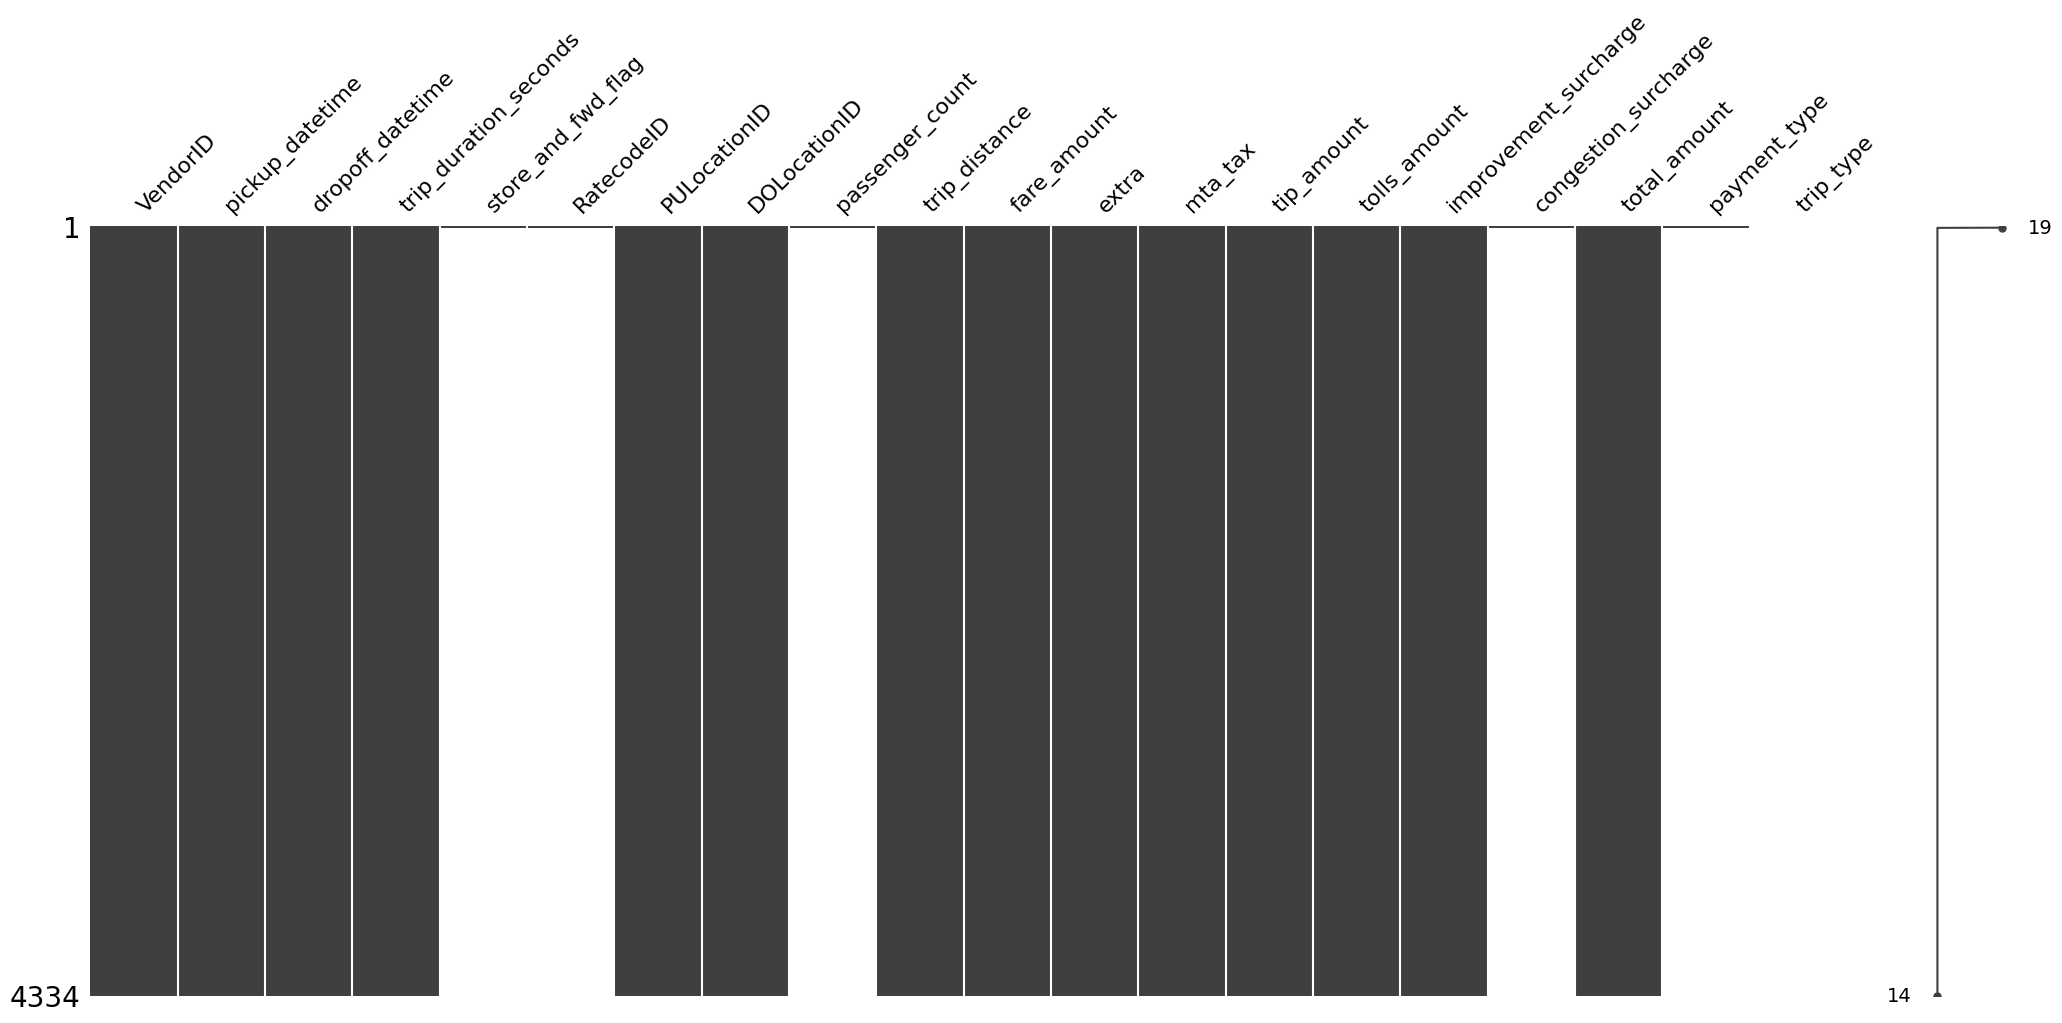

In [15]:
msno.matrix(df[df.trip_type.isna().values].drop(columns='ehail_fee'))

<u>**Insight**</u>
<br>Secara keseluruhan, ada **4334** missing values yang terlihat disebabkan oleh dua kemungkinan, karena nilai RatecodeID dan store_and_fwd_flag. Kedua kemungkinan ini akan diteliti lebih lanjut.

<Axes: >

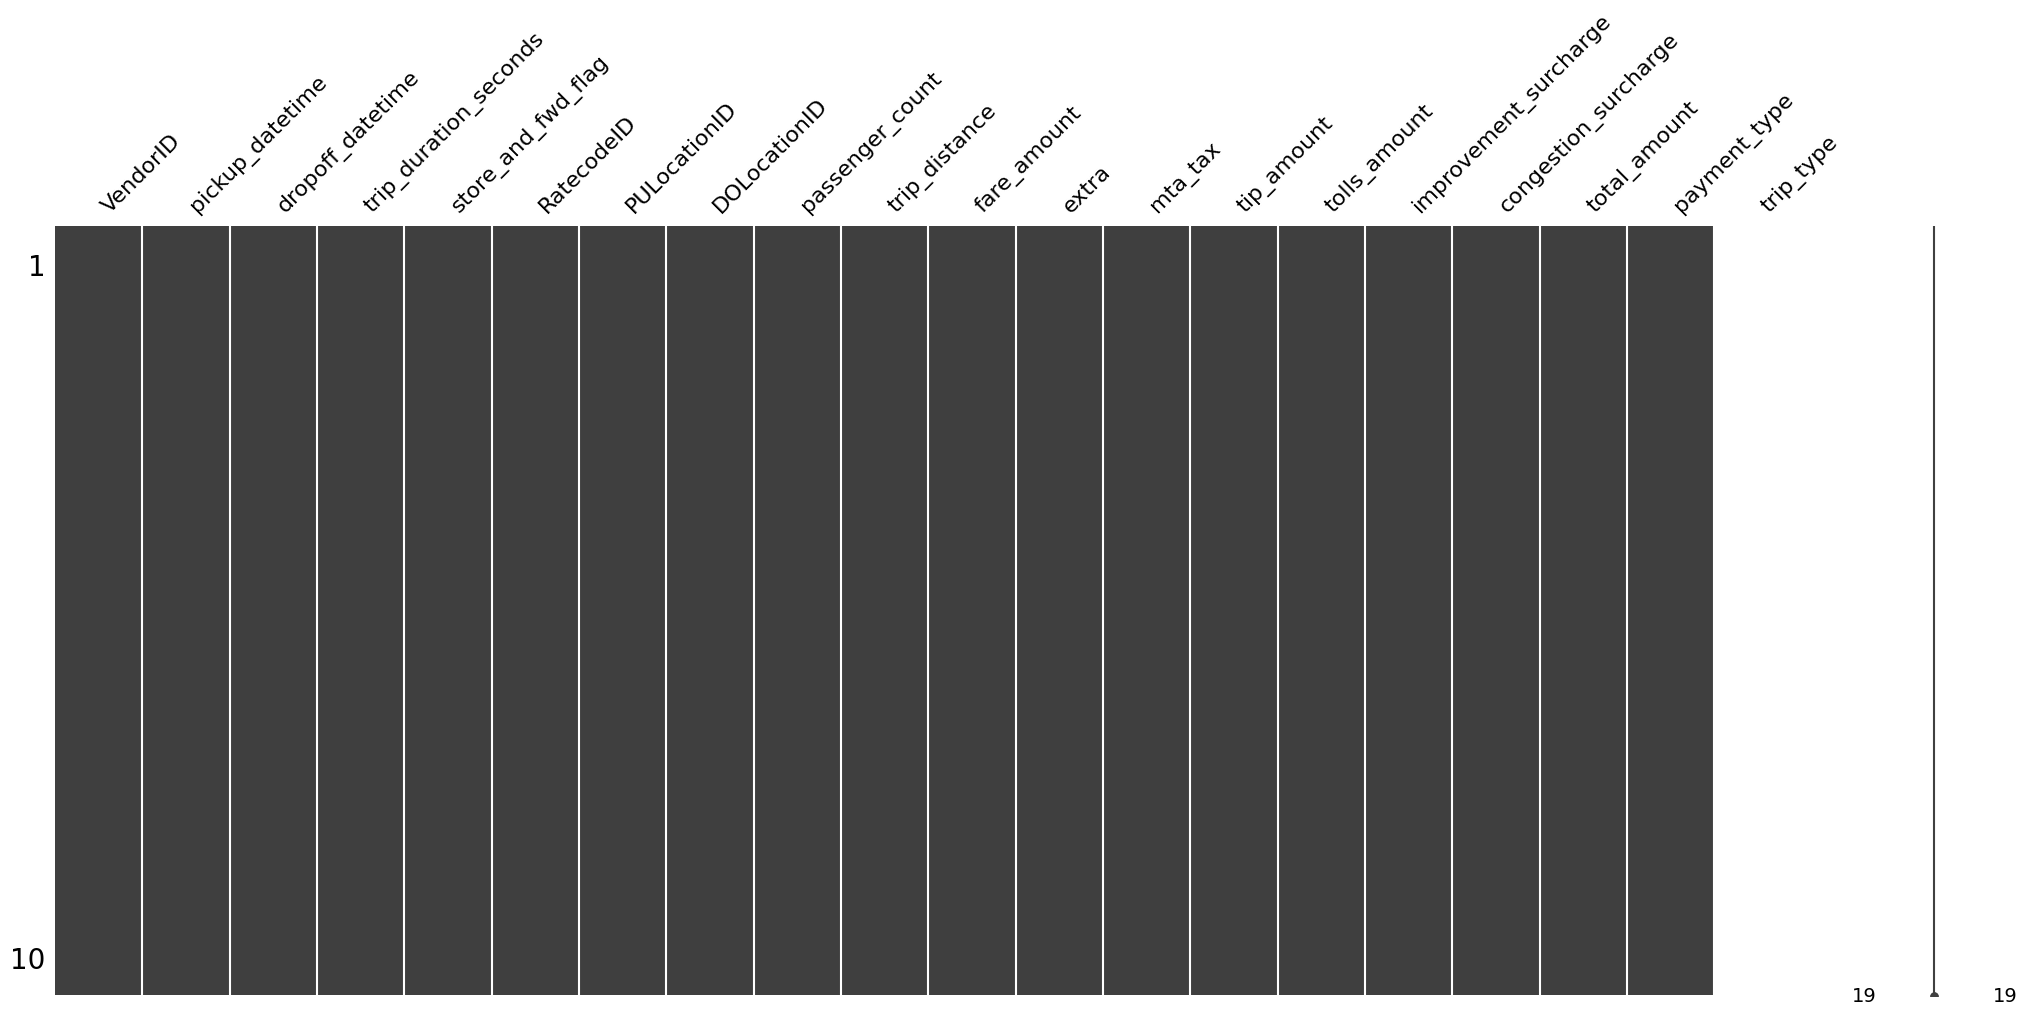

In [16]:
msno.matrix(df[(df.store_and_fwd_flag.notna().values) & (df.RatecodeID == 99)].drop(columns='ehail_fee'))

<u>**Insight**</u>
<br>Ditemukan bahwa ketika RatecodeID = 99, semua kolom trip_type tidak mempunyai nilai (ada sebanyak **10** poin data)

<Axes: >

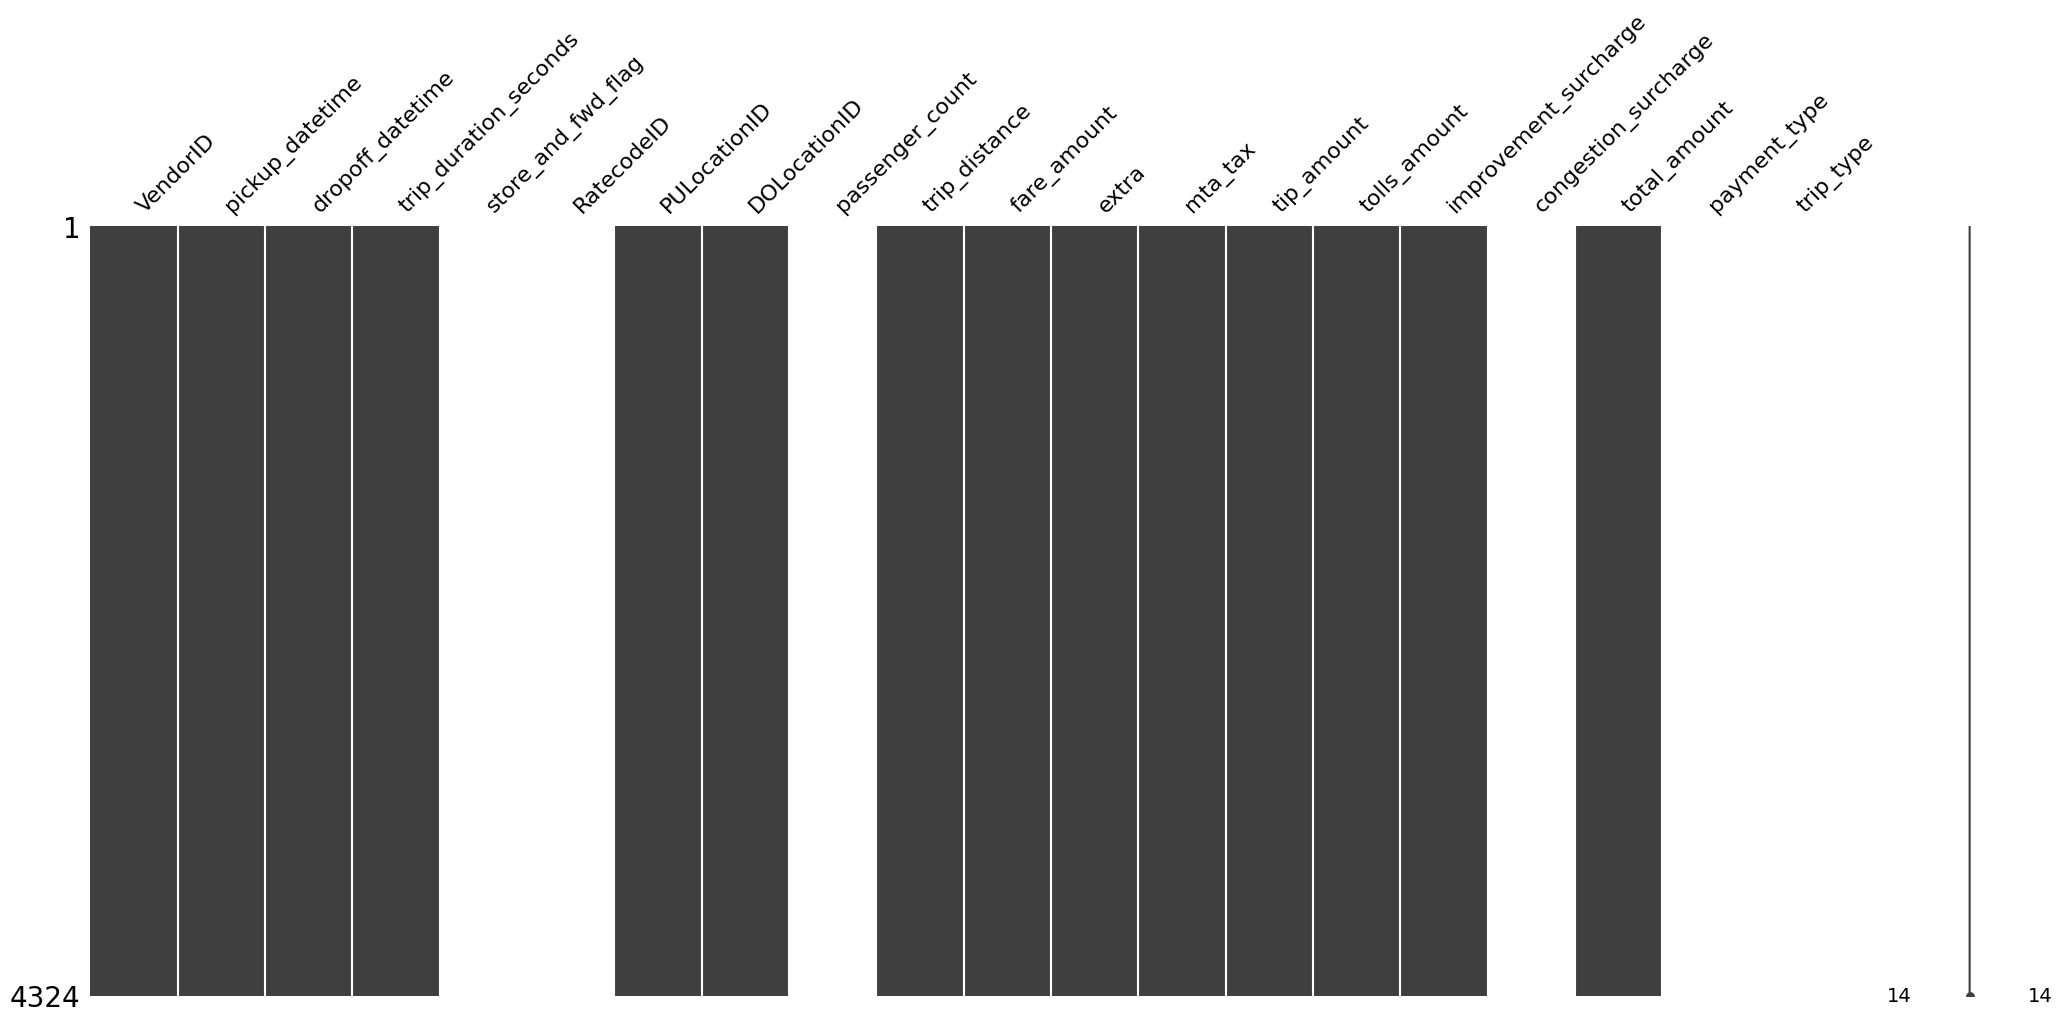

In [17]:
msno.matrix(df[(df.store_and_fwd_flag.isna().values) & (df.RatecodeID != 99)].drop(columns='ehail_fee'))

<Axes: >

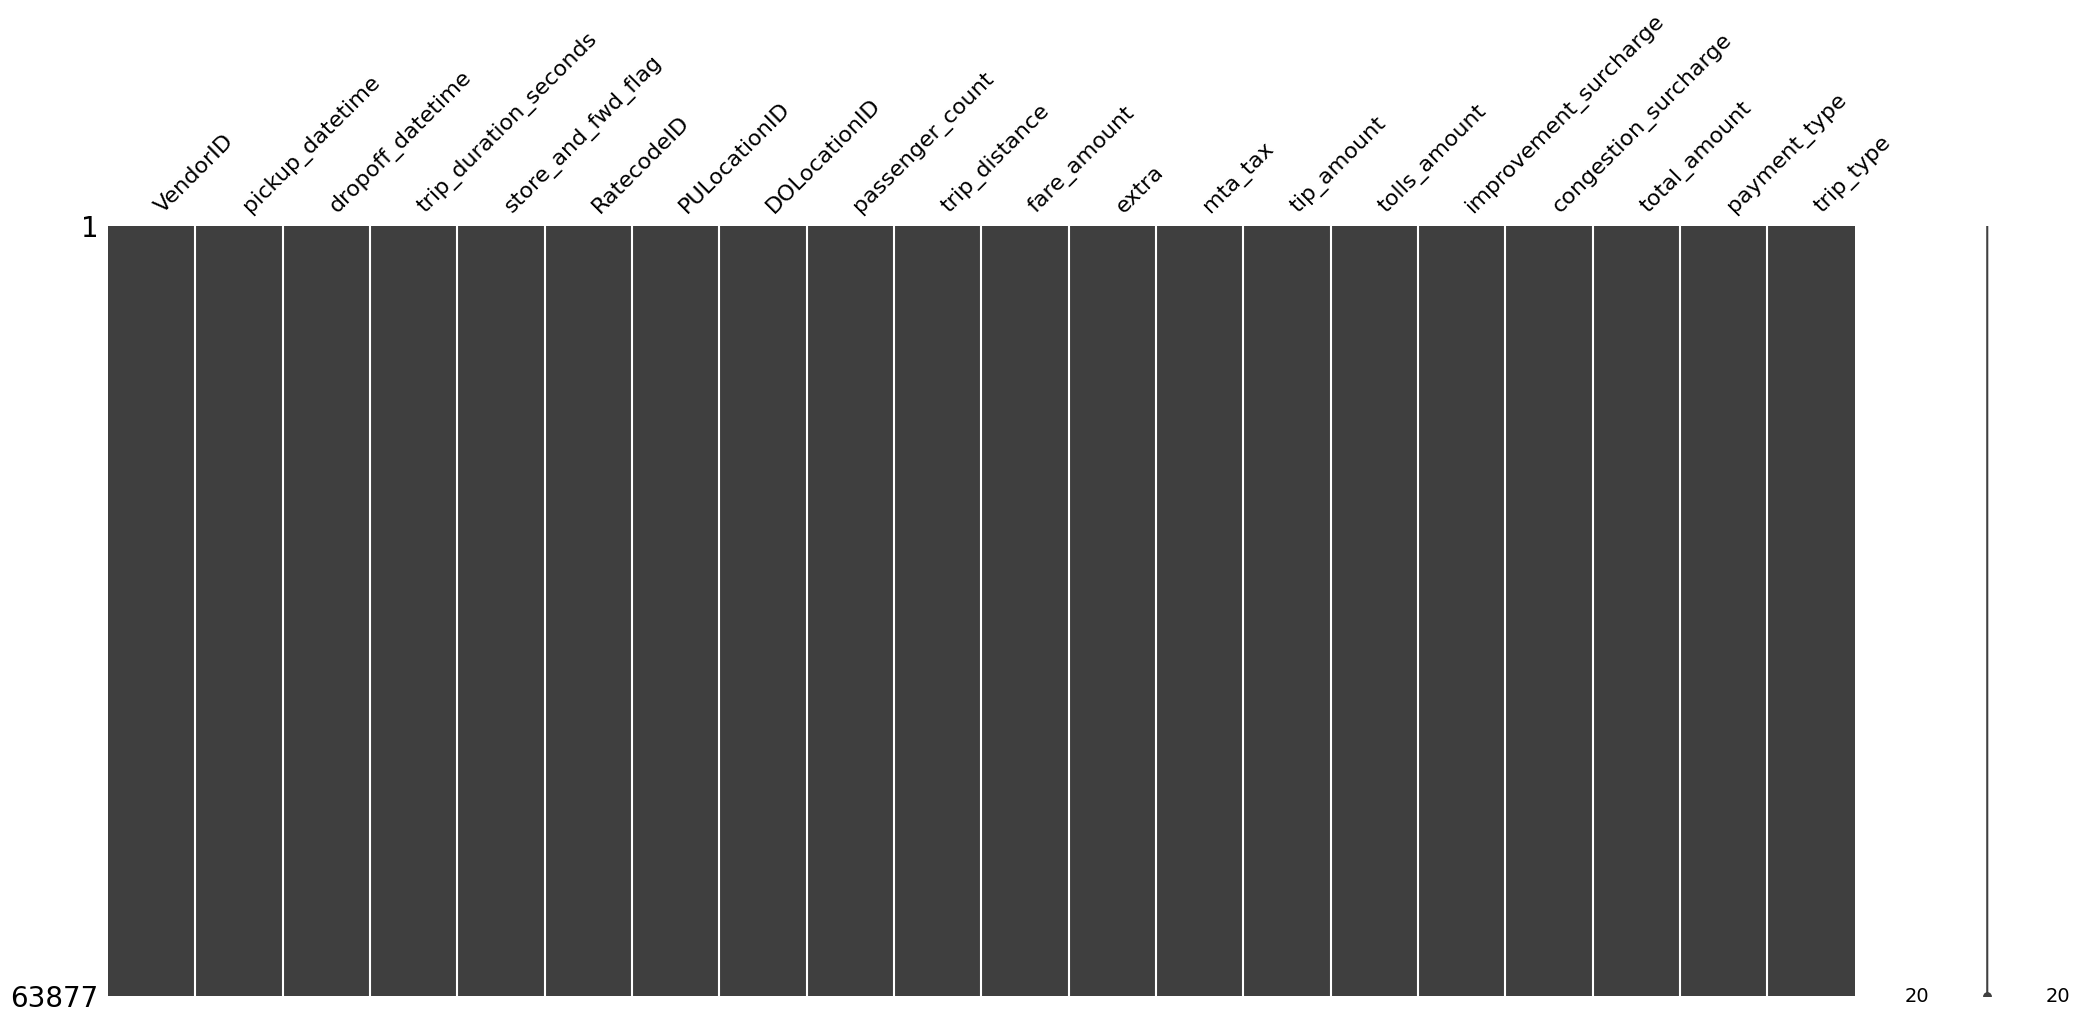

In [18]:
msno.matrix(df[(df.store_and_fwd_flag.notna().values) & (df.RatecodeID != 99)].drop(columns='ehail_fee'))

<u>**Insight**</u>
<br>Di sisa missing values yang ada (sebanyak **4324** poin data atau sekitar **6.33%**) terlihat bahwa ketika store_and_fwd_flag tidak diketahui nilainya, kolom RatecodeID, passenger_count, congestion_surcharge, payment_type, dan trip_type juga tidak ada nilainya. Sementara ketika store_and_fwd_flag ada nilainya, kelima kolom tersebut juga mempunyai nilai. Dengan begitu, dapat diasumsikan bahwa missing values pada kolom RatecodeID, passenger_count, congestion_surcharge, payment_type, dan trip_type bersifat **Missing At Random (MAR)**. Selanjutnya, handling missing values untuk kolom ini akan mengikuti handling missing values untuk data MAR.

## **1.5 Distribution of Continuous Data & Outliers**

Dari skimming data awal, ada 5 atribut data set yang mempunyai tipe data numerical dan continuous yaitu trip_distance, trip_duration, fare_amount, tip_amount, dan total_amount. Akan tetapi, total_amount merupakan penjumlahan dari kolom-kolom tarif dan perlu dihitung ulang setelah melakukan data cleansing. Untuk pemahaman data saat ini, hanya trip_distance, trip_duration, fare_amount, dan tip_amount yang akan dieksplorasi distribusi dan outliernya.

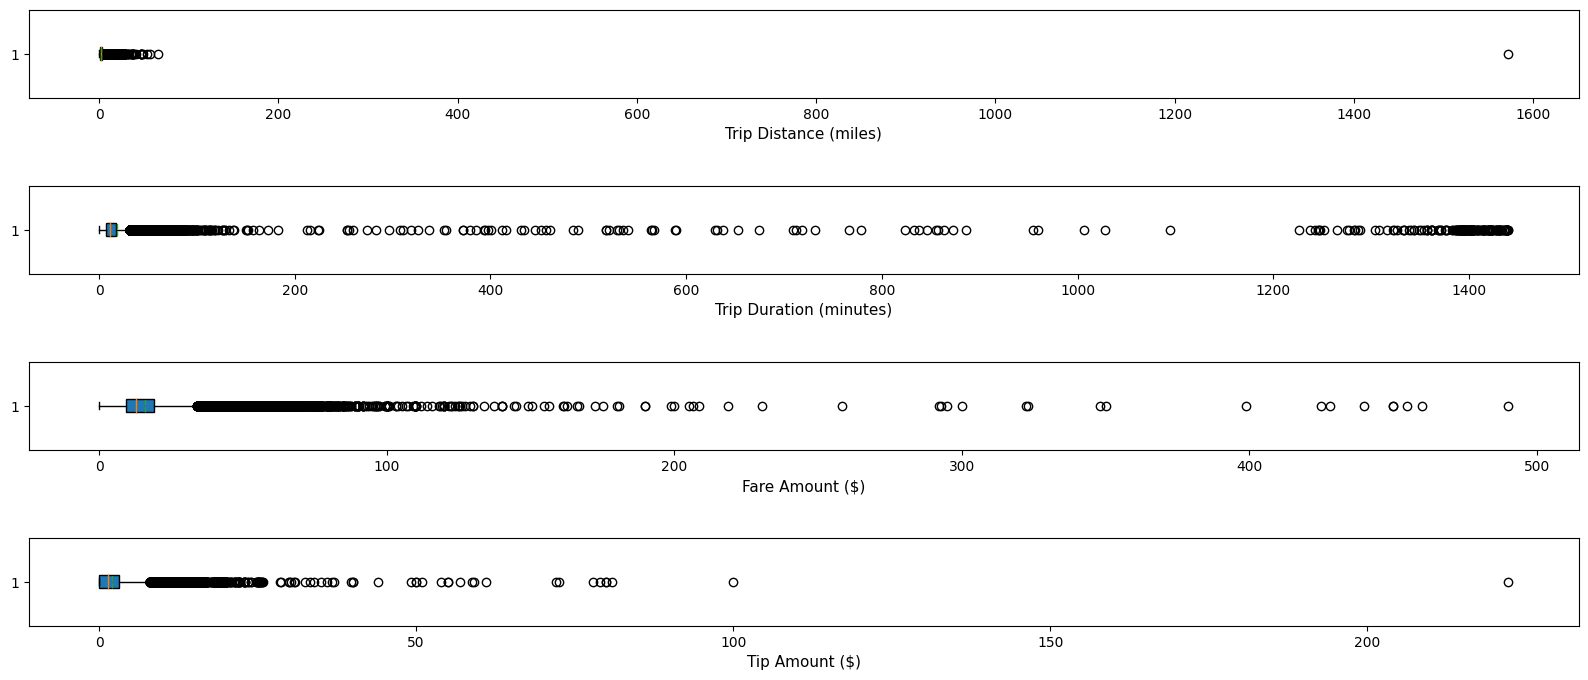

In [19]:
# exclude column ehail_fee and nan values
trip_distance = df.drop(columns='ehail_fee').dropna().trip_distance
trip_duration_minutes = df.drop(columns='ehail_fee').dropna().trip_duration_seconds.apply(lambda x: x/60)
fare_amount = df.drop(columns='ehail_fee').dropna().fare_amount.apply(abs)
tip_amount = df.drop(columns='ehail_fee').dropna().tip_amount.apply(abs)

fig, axes = plt.subplots(4, 1, figsize=(20, 8))
axes[0].boxplot(trip_distance, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[1].boxplot(trip_duration_minutes, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[2].boxplot(fare_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[3].boxplot(tip_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)

axes[0].set_xlabel("Trip Distance (miles)", fontsize=11)
axes[1].set_xlabel("Trip Duration (minutes)", fontsize=11)
axes[2].set_xlabel("Fare Amount ($)", fontsize=11)
axes[3].set_xlabel("Tip Amount ($)", fontsize=11)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=1)
plt.show()

<u>**Insight**</u>
<br>Pengamatan distribusi continuous data adalah tanpa nilai missing values. Secara grafik, terlihat jelas adanya outlier pada setiap atribut yang mengindikasikan distribusi data keempat atribut adalah tidak normal.

Rentang data dapat dibatasi berdasarkan domain knowledge yaitu:
* Kemungkinan jarak terjauh yang ditempuh antara dua titik dalam New York City dari Google Maps adalah 48.5 mil
* Durasi maksimal satu perjalanan taksi adalah 12 jam sesuai ketentuan dari NYC TLC (referensi: https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_54.pdf)
* Jumlah tip secara logika kurang masuk akal jika nilainya lebih besar dari 2 kali nilai tarif dasar (fare_amount)

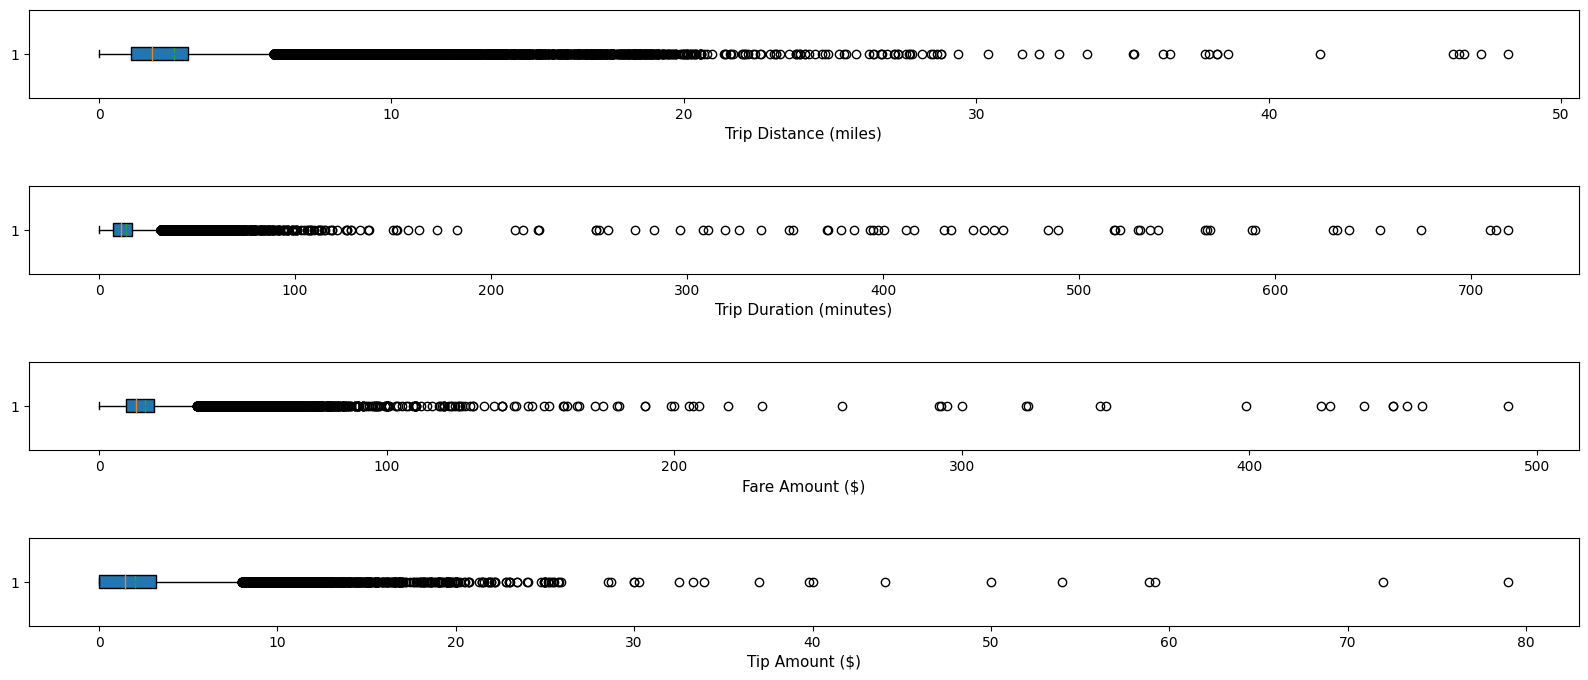

In [20]:
# memfilter jarak tempuh <= 48.5 mil
trip_distance = df[df.trip_distance <= 48.5].drop(columns='ehail_fee').dropna().trip_distance
# memfilter durasi perjalanan <= 12 jam
trip_duration_minutes = df[df.trip_duration_seconds <= 12*3600].drop(columns='ehail_fee').dropna().trip_duration_seconds.apply(lambda x: x/60)
fare_amount = df.drop(columns='ehail_fee').dropna().fare_amount.apply(abs)
# memfilter jumlah tip <= 2 kali jumlah tarif perjalanan
tip_amount = df[df.tip_amount <= 2*df.fare_amount].drop(columns='ehail_fee').dropna().tip_amount.apply(abs)

fig, axes = plt.subplots(4, 1, figsize=(20, 8))
axes[0].boxplot(trip_distance, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[1].boxplot(trip_duration_minutes, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[2].boxplot(fare_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[3].boxplot(tip_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)

axes[0].set_xlabel("Trip Distance (miles)", fontsize=11)
axes[1].set_xlabel("Trip Duration (minutes)", fontsize=11)
axes[2].set_xlabel("Fare Amount ($)", fontsize=11)
axes[3].set_xlabel("Tip Amount ($)", fontsize=11)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=1)
plt.show()

<u>**Insight**</u>
<br>Outlier masih ada meskipun rentang data beberapa atribut sudah dibatasi. Akan tetapi, nilai median (garis berwarna oranye) dan nilai rata-rata (garis dash berwarna hijau) dari setiap atribut terlihat sedikit lebih jelas dan nilai keduanya tidak beririsan, yang memang merupakan salah satu karakteristik lain dari data dengan distribusi tidak normal.

## **1.6 Summary**